In [1]:
%pylab inline
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import time
import random
import h5py
import numpy as np

from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

plt.style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


## Fonctions intermédiaires

In [2]:
#Foncion pour avoir la répartition des classes de label dans les données d'apprentissage
def proportion_classe(y_train):
    return len(y_train[y_train["label"]==0])/len(y_train), len(y_train[y_train["label"]==1])/len(y_train), len(y_train[y_train["label"]==2])/len(y_train), len(y_train[y_train["label"]==3])/len(y_train),len(y_train[y_train["label"]==4])/len(y_train)

In [3]:
#Fonction pour récupérer des données à partir d'un fichier h5, d'un nom de base et d'une liste de label
#On peut choisir de normaliser ou non ces données
def base_recup_key(fichier,key,output_train,normalize=False):
    
    h5 = h5py.File(fichier, "r")
    
    if normalize==True:
        min_max_scaler = preprocessing.MinMaxScaler()
        inputs=pd.DataFrame(min_max_scaler.fit_transform(h5[key][:]))
    else:
        inputs=pd.DataFrame(h5[key][:])
    
    if fichier=="train.h5":
        return pd.concat([inputs,output_train["label"]],axis=1)
    else:
        return inputs

In [4]:
#Fonction pour avoir un score de précision classique à partir d'une matrice de confusion 
#et de l'échantillon de test
#Penser à mettre le score de Cohen Kappa
def score(cm,y_test_1):
    score=0
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i!=j:
                score+=cm[i,j]
    return 1-score/len(y_test_1)

In [21]:
#Fonction pour faire une prédiction à partir d'un RFC sur une base et qui récupère les variables les plus 
#importantes dans la prédiction (paramètre à choisir)
#on met 200 arbres dans la forêt et 2 observations minimales par noeud
def var_importante(base,prop_train,nb_var):
    
    base_train=base[:int(len(base)*prop_train)]
    base_test=base[int(len(base)*prop_train):]
    #print("train",proportion_classe(base_train))
    #print("test",proportion_classe(base_test))
    
    X_train=base_train.drop("label",axis=1)
    X_test=base_test.drop("label",axis=1)
    y_train=base_train["label"]
    y_test=base_test["label"]
    #print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

    modele=ensemble.RandomForestClassifier(n_estimators=200,min_samples_leaf=2,n_jobs=2)
    modele.fit(X_train,y_train)
    y_pred=modele.predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    #print(cm)
    
    #importance des variables 
    feature_importance = modele.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-nb_var:]
    print("score",score(cm,y_test))

    return score(cm,y_test), modele ,sorted_idx

In [6]:
#Récupération des bases complète d'apprentissage et de test, réduites aux variables les plus importantes
#grâce à la fonction précédente 
def construction_bases(list_keys,pourcentage_var,nb_obs,output_train):
    dic_base_train={}
    dic_base_test={}
    
    for k in list_keys:
        print(k)
    
        b_train=base_recup_key("train.h5",k,output_train)
        v_i=var_importante(b_train[:nb_obs],0.75,int(pourcentage_var*np.shape(b_train)[1]))
    
        dic_base_train[k]=b_train.iloc[:,v_i[2]]
        dic_base_test[k]=base_recup_key("test.h5",k,output_train).iloc[:,v_i[2]]

    base_train=pd.concat([dic_base_train[k] for k in list_keys],axis=1,ignore_index=True)
    base_test=pd.concat([dic_base_test[k] for k in list_keys],axis=1,ignore_index=True)
    
    return pd.concat([base_train,output_train["label"]],axis=1), base_test

In [7]:
#On associe à chaque base de test sa base de train correspondante
def CV(base,nb_CV):
            
    nb=int(len(base)/nb_CV)
    separ_test=[base[i*nb:(i+1)*nb] for i in range (nb_CV)]

    separ_train=[]
    list_train=[[] for p in range(nb_CV)]
    for i in range(nb_CV):
        l=[j for j in range(nb_CV)]
        l.remove(i)
        for p in l:
            list_train[i].append(separ_test[p])
        separ_train.append(pd.concat(list_train[i]))
        
    return (separ_train,separ_test)

In [19]:
def choix_estimateur(modele, bases_CV,nb_CV, param_1,param_2):
    l_res={}
    for i in param_1:
        l_res[i]={}
        for j in param_2:
            l_res[i][j]=[]
    for i in range(nb_CV):
        #print(i)
        X_train=bases_CV[0][i].drop("label",axis=1)
        y_train=bases_CV[0][i]["label"]
        X_test=bases_CV[1][i].drop("label",axis=1)
        y_test=bases_CV[1][i]["label"]
        #print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

        for j in param_1:
            #print("min_leaf",j)
            for p in param_2:
                #print("arbres",p)
                
                mod=modele(n_estimators=p,min_samples_leaf=j,n_jobs=2)
                    
                #t2=time.time()    
                mod.fit(X_train,y_train)
                y_pred=mod.predict(X_test)
                #t3=time.time()
                #print(t3-t2)
                cm=confusion_matrix(y_test,y_pred)
                #print(cm)
                l_res[j][p].append(score(cm,y_test))
    return l_res

## Etude préalable

In [9]:
#Récupération de y_train
output_train=pd.read_csv("output_training.csv", sep=";")

In [10]:
#il y a 11.2% de cycle 0; 3.1% de cycle 1; 36.8% de cycle 2; 31.4% de cycle 3 et 17.4% de cycle 4
proportion_classe(output_train)

(0.11268537531371207,
 0.031006160164271046,
 0.36821811544604155,
 0.31439653205566964,
 0.17369381702030573)

Test de récupération de la base eeg_1.

In [11]:
#5s pour récupérer 43 000 * 3751 data
t0=time.time()
eeg_1=base_recup_key("train.h5","eeg_1",output_train)
t1=time.time()
print(t1-t0)

4.968879699707031


In [12]:
t0=time.time()
s_1=var_importante(eeg_1[:1000],0.75,100)
t1=time.time()
print(t1-t0)

score 0.532
2.1737749576568604


On regarde les 20 variables les plus importantes dans la prédiction du RFC sur la base eeg_1

Text(0.5,1,'Variable Importance')

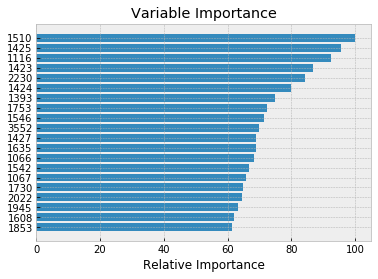

In [13]:
feature_name = eeg_1.columns
limit = 20
feature_importance = s_1[1].feature_importances_[:]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-limit:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

## Construction des bases d'apprentissage et de test

But: construire une base regroupant les 10% des variables les plus importantes pour la prédiction.

En effet, j'aurais bien chargé l'ensemble des données sur mon ordinateur mais l'import des données de test et des données de train me prend plus que mes 8 Go de RAM, c'est pour ça que j'ai commencé par réduire le nombre de variables à considérer

In [15]:
list_keys=['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'po_ir', 'po_r', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z']

In [16]:
#on garde 10% des meilleures variables de la prédiction sur chaque dataset 
pourcentage_var=0.2
#on fixe le nombre d'observation que l'on utilisera pour faire tourner notre modèle basique sur les sous bases
nb_obs=10000
t0=time.time()
base_train, base_test=construction_bases(list_keys,pourcentage_var,nb_obs,output_train)
t1=time.time()
print(t1-t0)

eeg_1
score 0.6008
eeg_2
score 0.5732
eeg_3
score 0.4248
eeg_4
score 0.4524
po_ir
score 0.3516
po_r
score 0.348
accelerometer_x
score 0.3944
accelerometer_y
score 0.3932
accelerometer_z
score 0.4264
556.2314908504486


Il semblerait que les bases eeg permettent de mieux détecter les cycles du sommeil que les autres bases. Ceci dit, nous n'avons pris que 10 000 observations pour entrainer un modèle basique, et il s'agissait des 10 000 premières ... 
De plus, les bases eeg contiennent 3 fois plus de variables que les autres bases donc la meilleure précision peut s'expliquer par ça 

In [17]:
print(np.shape(base_train),np.shape(base_test))

(43830, 4501) (20592, 4500)


## Cross validation sur les données d'apprentissage

In [20]:
#on est sur 5000 obs et 2250 variables et on fait une CV sur 5 sous-bases
nb_CV=5
nb_obs=10000
nb_tree=[20,50,100,200,400]
min_leaf=[1,3,6,10]
#on choisit aléatoirement les observations de la base qui servira pour la Cross Validation
base_CV=base_train.iloc[random.sample([i for i in range(len(base_train))],nb_obs),:].reset_index().drop(["index"],axis=1)
t0=time.time()
est_RFC=choix_estimateur(ensemble.RandomForestClassifier,CV(base_CV,nb_CV),nb_CV,min_leaf,nb_tree)
t1=time.time()
print(t1-t0)


5561.840124845505


On regarde de manière graphique l'influence des hyperparamètres sur la précision et la variance des prédictions

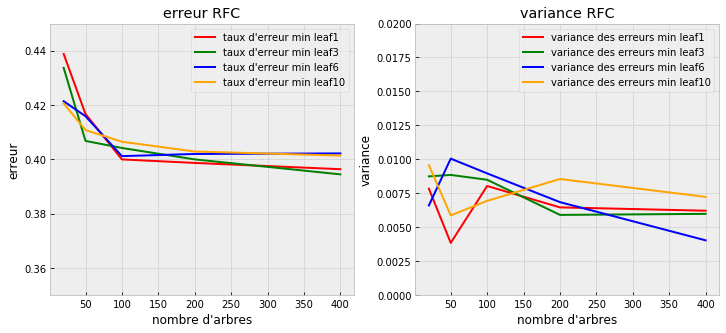

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

colors=["red","green","blue","orange","purple","yellow"]

for j in range(len(min_leaf)):
    ax1.plot([i for i in nb_tree],[1-np.mean(est_RFC[min_leaf[j]][i]) for i in nb_tree],color=colors[j],label="taux d'erreur min leaf"+str(min_leaf[j]))
    ax2.plot([i for i in nb_tree],[np.std(est_RFC[min_leaf[j]][i]) for i in nb_tree],color=colors[j],label="variance des erreurs min leaf"+str(min_leaf[j]))


ax1.set_title("erreur RFC")
ax1.set_ylim(0.35,0.45)
ax1.set_xlabel("nombre d'arbres")
ax1.set_ylabel("erreur")
ax1.legend(loc=0)

ax2.set_title("variance RFC")
ax2.set_ylim(0,0.02)
ax2.set_xlabel("nombre d'arbres")
ax2.set_ylabel("variance")
ax2.legend(loc=0)

Le taux d'erreur a l'air de converger vers 0.40 pour l'ensemble des feuilles à mesure qu'on augmente le nombre d'arbres dans la forêt. On remarque cependant que pour 10 observations minimales par feuille, le taux d'erreur remonte lorsqu'on atteint 200 arbres dans la forêt donc il est possible que cette condition soit trop contraignante.

La variance, elle, augmente avec le nombres d'arbres dans la forêt mais la différence n'est pas si grande entre 100 et 200 arbres. Il faudrait tester sur un plus grand nombre d'arbre pour voir l'évolution.

### Récupération données test et prédiction finale

On fait la prédiciton pour 400 arbres dans la forêt et 3 observations minimales par feuille.
La différence n'est pas énorme avec les autres paramètres mais c'est en attendant de tester d'autres valeurs pour ceux-ci.

In [25]:
t0=time.time()
X_train=base_train.drop("label",axis=1)
y_train=base_train["label"]
modele=ensemble.RandomForestClassifier(n_estimators=400,min_samples_leaf=3,n_jobs=2)
modele.fit(X_train,y_train)
t1=time.time()
print(t1-t0)
y_pred=modele.predict(base_test)

1091.0308072566986


In [26]:
base_pred=pd.DataFrame(y_pred,columns=["label"])

In [27]:
base_pred.to_csv("pred_400_3.csv",index_label="id",sep=";")

In [28]:
proportion_classe(base_pred)

(0.050165112665112664,
 0.0,
 0.5457944832944833,
 0.34105477855477856,
 0.06298562548562549)

In [30]:
proportion_classe(output_train)

(0.11268537531371207,
 0.031006160164271046,
 0.36821811544604155,
 0.31439653205566964,
 0.17369381702030573)

Si j’avais eu plus de temps :
-	j’aurais implémenté la métrique de Cohen Kappa
-	j’aurais testé d’autres modèles
-	j’aurais réfléchi à une meilleure manière de normaliser les données 
-   j'aurais essayer de réduire le nb de features par sous bases avec des méthodes différentes (notamment l'ACP)
-   j'aurais exploré un peu plus profondément les distributions des variables et d'éventuelles corrélations
